# Testing a Computer Vision model with PyTorch
PyTorch is an open-source machine learning framework developed primarily by Facebook's AI Research lab (FAIR). It is designed to provide a flexible and dynamic platform for building and training machine learning models, particularly deep neural networks. We are going to use PyTorch to implement a neural network to detect our robots.

## Imports

In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
from typing import Tuple, Union, Any
from torchvision.models import detection
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import warnings
warnings.filterwarnings('ignore')

## Utils functions
We are going to define some functions that will be used during the network training. Read the docstrings (comments explaining the functions) to understand them.

In [2]:
def set_seed(seed: int) -> None:
    """
    Define a seed for reproducibility. It allows experiment repetition obtaining the exact same results.
    :param seed: integer number indicating which seed you want to use.
    :return: None.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    # random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def get_inner_model(model: detection) -> Any:
    """
    PyTorch provides a model wrapper to enable multiple GPUs. This function returns the inner model (without wrapper).
    :param model: Torch model, with or without nn.DataParallel wrapper.
    :return: if model is wrapped, it returns the inner model (model.module). Otherwise, it returns the input model.
    """
    return model.module if isinstance(model, torch.nn.DataParallel) else model


def torch_load_cpu(load_path: str) -> Any:
    """
    Load the data saved from a trained model (model weights, optimizer state, last epoch number to resume training...)
    :param load_path: string indicating the path to the data saved from a trained model.
    :return: dictionary containing data saved from a trained model.
    """
    return torch.load(load_path, map_location=lambda storage, loc: storage)  # Load on CPU


def load_model_path(path: str, model: detection, device: torch.device, optimizer: torch.optim = None) -> Tuple[Any, Any, int]:
    """
    Load the trained weights of a model into the given model.
    :param path: string indicating the path to the trained weights of a model.
    :param model: the model where you want to load the weights.
    :param device: whether gpu or cpu is being used.
    :param optimizer: the optimizer initialized before loading the weights.
    :return:
        model: Torchvision model.
        optimizer: Torch optimizer.
        history: training history.
    """

    # Load model state
    load_data = torch_load_cpu(path)
    model.load_state_dict({**model.state_dict(), **load_data.get('model', {})})
    # model_ = get_inner_model(model)
    # model_.load_state_dict({**model_.state_dict(), **load_data.get('model', {})})

    # Load rng state
    torch.set_rng_state(load_data['rng_state'])
    if torch.cuda.is_available():
        torch.cuda.set_rng_state_all(load_data['cuda_rng_state'])

    # Load optimizer state
    if 'optimizer' in load_data and optimizer is not None:
        optimizer.load_state_dict(load_data['optimizer'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.to(device)

    # Get initial epoch and training history
    history = load_data['history']

    return model, optimizer, history


def torchvision_model(model_name: str, pretrained: bool = False, num_classes: int = 2) -> Any:
    """
    Return a model from a list of Torchvision models.
    :param model_name: name of the Torchvision model that you want to load.
    :param pretrained: whether pretrained weights are going to be loaded or not.
    :param num_classes: number of classes. Minimum is 2: 0 = background, 1 = object.
    :return:
        model: Torchvision model.
    """

    # Torchvision models
    model_dict = {
        'faster_rcnn_v1': detection.fasterrcnn_resnet50_fpn,
        'faster_rcnn_v2': detection.fasterrcnn_resnet50_fpn_v2,
        'faster_rcnn_v3': detection.fasterrcnn_mobilenet_v3_large_fpn,
        # 'faster_rcnn_v4': detection.fasterrcnn_mobilenet_v3_large_320_fpn,
        # 'fcos_v1': detection.fcos_resnet50_fpn,
        'retinanet_v1': detection.retinanet_resnet50_fpn,
        'retinanet_v2': detection.retinanet_resnet50_fpn_v2,
        'ssd_v1': detection.ssd300_vgg16,
        'ssd_v2': detection.ssdlite320_mobilenet_v3_large,
    }

    # Create model and load pretrained weights (if pretrained=True)
    if model_name in model_dict:
        model = model_dict[model_name](weights='COCO_V1' if pretrained else None)

        # Modify the model's output layer for the number of classes in your dataset
        if 'faster_rcnn' in model_name:
            in_features = model.roi_heads.box_predictor.cls_score.in_features
            model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
        elif 'retinanet' in model_name:
            in_features = model.head.classification_head.cls_logits.in_channels
            num_anchors = model.head.classification_head.num_anchors
            model.head.classification_head = detection.retinanet.RetinaNetClassificationHead(
                in_features, num_anchors, num_classes
            )
        elif 'fcos' in model_name:
            in_features = model.head.classification_head.cls_logits.in_channels
            num_anchors = model.head.classification_head.num_anchors
            model.head.classification_head = detection.fcos.FCOSClassificationHead(
                in_features, num_anchors, num_classes
            )
        elif 'ssd_v1' in model_name:
            in_features = [module.in_channels for module in model.head.classification_head.module_list]
            num_anchors = model.anchor_generator.num_anchors_per_location()
            model.head.classification_head = detection.ssd.SSDClassificationHead(
                in_features, num_anchors, num_classes
            )
        elif 'ssd_v2' in model_name:
            in_features = [module[0][0].in_channels for module in model.head.classification_head.module_list]
            num_anchors = model.anchor_generator.num_anchors_per_location()
            model.head.classification_head = detection.ssd.SSDClassificationHead(
                in_features, num_anchors, num_classes
            )

    # Error: Model not in list
        else:
            assert False, 'Model {} not in list. Indicate a Torchvision model from the list.'.format(model_name)
    else:
        assert False, 'Model {} not in list. Indicate a Torchvision model from the list.'.format(model_name)

    return model


def get_model(
    model_name: str,
    model_path: str = '',
    num_classes: int = 2,
    lr_data: list = None,
    pretrained: bool = False,
    use_gpu: bool = False
) -> Tuple[Any, Any, int, torch.device]:
    """
    Main function to create and load the model.
    :param model_name: name of the Torchvision model to load.
    :param model_path: path to the model.
    :param num_classes: number of classes. Minimum is 2: 0 = background, 1 = object.
    :param lr_data: list containing [learning rate, learning rate momentum, learning rate decay].
    :param pretrained: whether Torch pretrained weights on COCO dataset are going to be used or not.
    :param use_gpu: whether to use GPU or CPU.
    :return:
        model: Torch model.
        optimizer: Torch optimizer.
        history: training history.
        device: torch device indicating whether to use GPU or CPU.
    """

    # Define device (GPU or CPU)
    device_name = 'cuda' if use_gpu and torch.cuda.is_available() else 'cpu'
    device = torch.device(device_name)

    # Load Torchvision model
    model = torchvision_model(model_name, pretrained, num_classes).to(device)
    # if use_gpu and torch.cuda.is_available() and torch.cuda.device_count() > 1:
    #     model = torch.nn.DataParallel(model).cuda()

    # Define the optimizer
    if lr_data:
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=lr_data[0], momentum=lr_data[1], weight_decay=lr_data[2])
    else:
        optimizer = None

    # Load trained weights, optimizer state, and initial epoch
    if os.path.isfile(model_path):
        print(f"\t[*] Loading Torch model from '{model_path}'")
        model, optimizer, history = load_model_path(model_path, model, device, optimizer)
    else:
        history = {'train_loss': [], 'valid_loss': [], 'best_value': np.inf, 'current_epoch': 0}
        print(f"Model weights not found in '{model_path}'. Training from scratch.")

    return model, optimizer, history, device

## Data Generator
Data generators (called Datasets in Torch) are used to iteratively load images and annotations to feed neural networks during train, validation, and test.

In [3]:
class CustomDataset(Dataset):

    def __init__(self, path_dataset: str, resize_shape: tuple = None, transform: transforms.Compose = None) -> None:
        """
        Custom dataset that feeds the network during train, validation, and test.
        :param path_dataset: path to the dataset.
        :param resize_shape: tuple indicating height and width to resize images (for faster performance).
        :param transform: list of transforms to apply to the images.
        """
        print("Loading annotations...")
        self.annotations = parse_annotations(path_dataset)
        self.resize_shape = resize_shape
        self.transform = transform

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, dict]:
        """
        Get an index corresponding to one of the images and return the image and its annotation.
        :param idx: index of image to load.
        :return:
            image: Torch tensor containing the image with shape (Channels, Height, Width).
            targets: dictionary with the bounding boxes (boxes) and class labels (labels) of each annotated object.
        """
        # Get one annotation for the current index
        annotation = self.annotations[idx]

        # Load image
        image = Image.open(annotation['path_image']).convert("RGB")

        # Load bounding boxes
        boxes = self.annotations[idx]['boxes']
        boxes = torch.tensor(boxes)

        # Load labels (class of the object)
        labels = self.annotations[idx]['labels']
        labels = torch.tensor(labels).type(torch.int64)

        # If empty, reshape to [0, 4]
        if boxes.numel() == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        # Apply transforms
        if self.transform:
            w, h = image.size
            image, boxes, class_labels = self.transform(image, boxes, labels)
            if self.resize_shape:
                boxes = resize_boxes(boxes, self.resize_shape, (h, w))

        # Torchvision models use this structure for boxes and labels
        targets = {'boxes': boxes, 'labels': torch.tensor(labels)}

        return image, targets

    def __len__(self) -> int:
        """
        Length of the dataset.
        :return: number of annotated images contained in the dataset.
        """
        return len(self.annotations)


def resize_boxes(boxes: torch.Tensor, resize_shape: tuple, image_shape: tuple) -> torch.Tensor:
    """
    Resize the shape of the bounding boxes when the size of the images is also resized.
    :param boxes: Torch tensor containing bounding boxes with format: [x_min, y_min, x_max, y_max].
    :param resize_shape: new image size.
    :param image_shape: previous image size.
    :return:
        boxes: resized bounding boxes.
    """
    boxes[:, 0] *= resize_shape[1] / image_shape[1]
    boxes[:, 1] *= resize_shape[0] / image_shape[0]
    boxes[:, 2] *= resize_shape[1] / image_shape[1]
    boxes[:, 3] *= resize_shape[0] / image_shape[0]
    return boxes


def get_transform(norm: tuple, resize_shape: Union[tuple, None]) -> transforms.Compose:
    """
    Define data transformations and apply them to the dataset.
    :param norm: mean and std required by each Torchvision model to normalize the input images.
    :param resize_shape: new image size.
    :return:
        transform: list of transforms to apply to the images.
    """

    # Convert images to Torch tensors and apply the previous normalization
    t = [transforms.ToTensor(), transforms.Normalize(*norm)]

    # Resize images if required
    if resize_shape:
        t.append(transforms.Resize(resize_shape))
    return transforms.Compose(t)


def parse_annotations(path_dataset: str) -> list:
    """
    Read dataset structure and extract path to images and annotations.
    :param path_dataset: path to the dataset.
    :return:
        annotations: list of dictionaries, each with the path to the image, the bounding boxes, and the class labels.
    """

    # Search labels on each sequence
    annotations = []
    for sequence in tqdm(sorted(os.listdir(path_dataset))):
        if os.path.isdir(os.path.join(path_dataset, sequence)):
            path_sequence = os.path.join(path_dataset, sequence, 'labels')

            # Search labels on each frame
            for frame in sorted(os.listdir(path_sequence)):
                if os.path.isfile(os.path.join(path_sequence, frame)):                
                    path_frame_labels = os.path.join(path_sequence, frame)
    
                    # Load labels
                    image_name, boxes = read_label(path_frame_labels)
                    # if len(boxes) == 0:
                    #     continue
    
                    # Get path to the image
                    path_image = os.path.join(path_dataset, sequence, 'images', image_name)
    
                    # Save the path to the image, the boxes, and the labels (class of object) in a dictionary
                    annotations.append({
                        'path_image': path_image,
                        'boxes': np.array(boxes),
                        'labels': np.array([1 for _ in range(len(boxes))])
                    })
    return annotations


def read_label(xml_file: str) -> Tuple[str, list]:
    """
    Read annotation xml file.
    :param xml_file: path to xml file.
    :return:
        image_name: string with the imnage filename.
        list_with_all_boxes: list of bounding boxes.
    """

    # Load xml data
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Load frame name
    image_name = root.find('filename').text

    # Load all bounding boxes
    list_with_all_boxes = []
    for boxes in root.iter('object'):

        # Get box
        ymin, xmin, ymax, xmax = None, None, None, None
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        
        # Skip boxes with missing values
        if (ymin is None) or (xmin is None) or (ymax is None) or (xmax is None):
            continue

        # Save box
        list_with_one_box = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_one_box)

    return image_name, list_with_all_boxes


def collate_fn(batch: list) -> tuple:
    """
    Avoids stacking images and annotations from dataloader as a Torch tensor, and stacks them as tuples.
    :param batch: images and annotations loaded from dataset.
    :return:
        batch: images and annotations stacked as tuples.
    """
    return tuple(zip(*batch))

## Parameters
Here, we define multiple parameters to test our network. Read them carefully, understand their utility, and play with them to obtain the best results.

In [4]:
local_path = '../..'

# Seed (for reproducibility) -> Do NOT change
seed = 0
set_seed(seed)

# Data parameters
path_dataset = f'{local_path}/dataset_test'             # Path to dataset

# Model parameters
model_name = 'faster_rcnn_v1'                             # Torchvision model
model_path = f'{local_path}/models/{model_name}/model.pt' # Path to save trained model
num_classes = 2                                           # Number of classes (ALWAYS 2: 0=background, 1=robot)
resize_shape = None                                       # Resize images for faster performance. None to avoid resizing
pretrained = True                                         # Use weights pre-trained on COCO dataset

# Test parameters
use_gpu = True                                            # Use GPU (True) or CPU (False)
num_workers = 0

# Other test parameters
batch_size = 16                                           # Batch size

## Test
Now, we have enough material to test our network. As before, we will create the model and load the trained weights.

In [5]:
# Load model
model, _, _, device = get_model(
    model_name=model_name,
    model_path=model_path,
    num_classes=num_classes,
    lr_data=None,
    pretrained=pretrained,
    use_gpu=use_gpu
)

	[*] Loading Torch model from '../../models/faster_rcnn_v1/model.pt'


## Quantitative results

Secondly, we need a data generator to iteratively load data.

In [6]:
# Image transformations
image_and_std = (model.transform.image_mean, model.transform.image_std)
transform = get_transform(image_and_std, resize_shape)

# Initialize your custom dataset
test_set = CustomDataset(
    path_dataset=path_dataset,
    resize_shape=resize_shape,
    transform=transform,
)

# Initialize your dataloader
test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate_fn,
)

Loading annotations...


100%|██████████| 9/9 [00:00<00:00, 10.09it/s]


Finally, we will test our model and get the mAP metric. Again, read the code carefully and understand every step.

In [7]:
# Set model in eval mode (no gradients)
model.eval()

# Evaluate (gradients are not necessary)
predictions_list, targets_list = [], []
with torch.no_grad():

    # Evaluate
    print('Load predictions:')
    for images, targets in tqdm(test_loader):

        # Move data to device
        images = torch.stack(images, dim=0).to(device)
        targets = [{k: v.to(device) for k, v in targets[t].items()} for t in range(len(images))]
        targets_list.extend(targets)

        # Predict and get loss value
        predictions = model(images)
        predictions_list.extend(predictions)

Load predictions:


100%|██████████| 82/82 [01:40<00:00,  1.23s/it]


In [8]:
# Metrics
mean_ap = MeanAveragePrecision()
metrics = mean_ap(predictions_list, targets_list)
print('Test:')
print(f'  mAP: {metrics["map"]:.4f}')
print(f'  mAP@0.50: {metrics["map_50"]:.4f}')
print(f'  mAP@0.75: {metrics["map_75"]:.4f}')
print(f'  mAP@Small: {metrics["map_small"]:.4f}')
print(f'  mAP@Medium: {metrics["map_medium"]:.4f}')
print(f'  mAP@Large: {metrics["map_large"]:.4f}')

Test:
  mAP: 0.6041
  mAP@0.50: 0.9363
  mAP@0.75: 0.6999
  mAP@Small: 0.2740
  mAP@Medium: 0.5391
  mAP@Large: 0.7024


### Qualitative results

It is important to qualitatively check if the model is working properly. The best manner is to plot the predicted bounding boxes on the image.

In [9]:
def plot_predictions(image, model_output, score_threshold=0.5):
    """
    Draws bounding box predictions from a torchvision model on an image using matplotlib.

    Args:
        image (np.ndarray): Input image in RGB format (e.g. from plt.imread).
        model_output (list[dict]): Output from a torchvision detection model.
        score_threshold (float): Minimum confidence score to show a detection.
    """
    preds = model_output[0]
    boxes = preds['boxes'].detach().cpu().numpy()
    scores = preds['scores'].detach().cpu().numpy()

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image)

    for box, score in zip(boxes, scores):
        if score < score_threshold:
            continue

        x1, y1, x2, y2 = box

        # Draw rectangle
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor="lime", facecolor="none"
        )
        ax.add_patch(rect)

        # Draw score with background for readability
        ax.text(
            x1, y1 - 9, f"{score:.2f}",
            fontsize=10, color="white", weight="bold",
            bbox=dict(facecolor="black", alpha=0.6, edgecolor="none", pad=1)
        )

    plt.axis("off")
    plt.show()

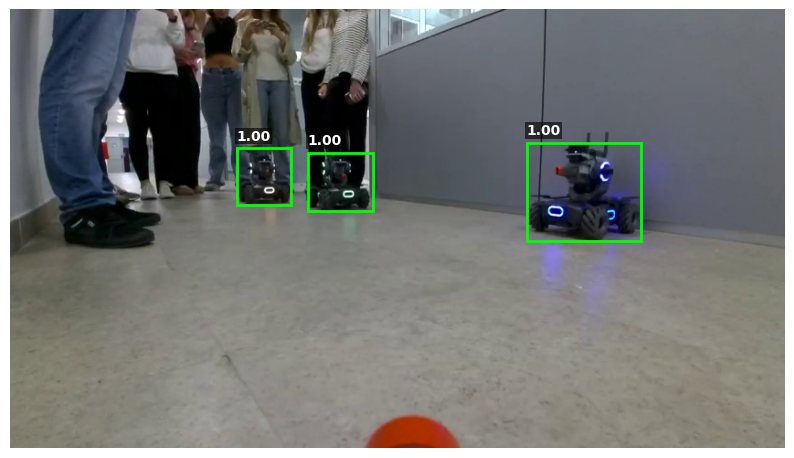

In [10]:
# Load image
image = plt.imread(f"{local_path}/dataset_test/PIDS2024_0001/images/frame_0009.jpg")

# Transform image
input_data = transform(image).to(device)

# Make predictions
outputs = model([input_data])

# Plot predictions
plot_predictions(image, outputs, score_threshold=0.5)